## pipeline

In [1]:
import numpy as np
import os
import pickle
import copy
import edt
import matplotlib.pyplot as plt
import time
import cv2
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
from skimage.metrics import adapted_rand_error

import torch
from torch import from_numpy as from_numpy
from torchsummary import summary

from func.run_pipeline_super_vox import segment_super_vox_3_channel, semantic_segment_crop_and_cat_3_channel_output, img_3d_erosion_or_expansion, \
generate_super_vox_by_watershed, get_outlayer_of_a_3d_shape, get_crop_by_pixel_val, Cluster_Super_Vox, assign_boudary_voxels_to_cells_with_watershed, \
delete_too_small_cluster, reassign
from func.run_pipeline import segment, assign_boudary_voxels_to_cells, dbscan_of_seg, semantic_segment_crop_and_cat
from func.cal_accuracy import IOU_and_Dice_Accuracy, VOI
from func.network import VoxResNet, CellSegNet_basic_lite_w_groupnorm, CellSegNet_basic_edge_gated_IV
from func.unet_3d_basic import UNet3D_basic
from func.ultis import save_obj, load_obj

### init model

In [2]:
# model=UNet3D_basic(in_channels = 1, out_channels = 3)
# load_path=''
# model=VoxResNet(input_channel=1, n_classes=3, output_func = "softmax")
# load_path=""
model=CellSegNet_basic_lite_w_groupnorm(input_channel=1, n_classes=3, output_func = "softmax")
load_path='output/model_HMS_epoch_499.pkl'
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])

# model.eval()
"""
for child in model.children():
    print(child)
    if type(child).__name__.startswith('BatchNorm'):
        child.track_running_stats = False
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#summary(model, (1, 64, 64, 64))

CellSegNet_basic_lite_w_groupnorm(
  (conv1): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bnorm1): GroupNorm(1, 32, eps=1e-05, affine=True)
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule1): ResModule_w_groupnorm(
    (groupnorm_module): GroupNorm(1, 64, eps=1e-05, affine=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule2): ResModule_w_groupnorm(
    (groupnorm_module): GroupNorm(1, 64, eps=1e-05, affine=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv5): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule3): ResModule_w_groupnorm(
    (groupnorm_module): GroupNorm(1, 64, eps=1e-05, affine=

### dataset info

In [3]:
HMS_data_dict = load_obj("dataset_info/HMS_dataset_info")
HMS_data_dict_test = HMS_data_dict["test"]

### seg one img

parameter setting

In [4]:
# we do not input the whole raw image to the model one time but input raw image crops
crop_cube_size=64
stride=32

# hyperparameter for TASCAN, min touching area of two super pixels if they belong to the same cell
min_touching_area=30

choose a test image and load it

In [5]:
print("Test cases: "+str(HMS_data_dict_test.keys()))
case = "135"
print("for test case "+str(case)+" : "+str(HMS_data_dict_test[case]))

# you may load the image using another path
raw_img=np.load(HMS_data_dict_test[case]["raw"]).astype(float)
hand_seg=np.load(HMS_data_dict_test[case]["ins"]).astype(float)

Test cases: dict_keys(['135', '120', '65', '90'])
for test case 135 : {'raw': 'data/CellSeg_dataset/HMS_processed/raw/135.npy', 'background': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_background_3d_mask.npy', 'edge': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_edge_3d_mask.npy', 'edge_foreground': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_edge_foreground_3d_mask.npy', 'centroid_foreground': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_centroid_foreground_3d_mask.npy', 'edge_background': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_edge_background_3d_mask.npy', 'boundary': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_boundary_3d_mask.npy', 'foreground': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_foreground_3d_mask.npy', 'ins': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_ins.npy'}


In [6]:
# get gt boundary

boundary_gt = np.load(HMS_data_dict_test[case]["boundary"]).astype(float)

feed raw image crops to the model

In [7]:
start = time.time()

# feed the raw img to the model
print('Feed raw img to model')
raw_img_size=raw_img.shape
    
seg_background_comp = np.zeros(raw_img_size)
seg_boundary_comp = np.zeros(raw_img_size)

transposes = [[0,1,2]]#,[2,0,1],[0,2,1]]
reverse_transposes = [[0,1,2]]#,[1,2,0],[0,2,1]]

for idx, transpose in enumerate(transposes):
    print(str(idx+1)+": Transpose the image to be: "+str(transpose))
    with torch.no_grad():
        seg_img =\
        semantic_segment_crop_and_cat_3_channel_output(raw_img.transpose(transpose), model, device, crop_cube_size=crop_cube_size, stride=stride)
    seg_img_background=seg_img['background']
    seg_img_boundary=seg_img['boundary']
    seg_img_foreground=seg_img['foreground']
    torch.cuda.empty_cache()
    
    # argmax
    print('argmax', end='\r')
    seg=[]
    seg.append(seg_img_background)
    seg.append(seg_img_boundary)
    seg.append(seg_img_foreground)
    seg=np.array(seg)
    seg_argmax=np.argmax(seg, axis=0)
    # probability map to 0 1 segment
    seg_background=np.zeros(seg_img_background.shape)
    seg_background[np.where(seg_argmax==0)]=1
    seg_foreground=np.zeros(seg_img_foreground.shape)
    seg_foreground[np.where(seg_argmax==2)]=1
    seg_boundary=np.zeros(seg_img_boundary.shape)
    seg_boundary[np.where(seg_argmax==1)]=1
        
    seg_background=seg_background.transpose(reverse_transposes[idx])
    seg_foreground=seg_foreground.transpose(reverse_transposes[idx])
    seg_boundary=seg_boundary.transpose(reverse_transposes[idx])
        
    seg_background_comp+=seg_background
    seg_boundary_comp+=seg_boundary
#print("Get model semantic seg by combination")
seg_background_comp = np.array(seg_background_comp>0, dtype=float)
seg_boundary_comp = np.array(seg_boundary_comp>0, dtype=float)
seg_foreground_comp = np.array(1 - seg_background_comp - seg_boundary_comp>0, dtype=float)

end = time.time()

print("Time elapsed: ", end - start)

Feed raw img to model
1: Transpose the image to be: [0, 1, 2]
s of segment_3d_img: 99%Time elapsed:  217.23372077941895


4

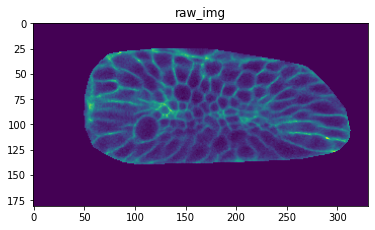

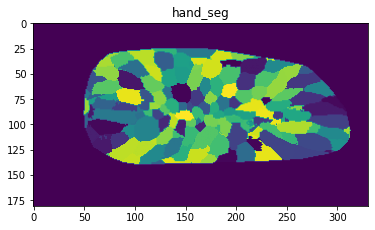

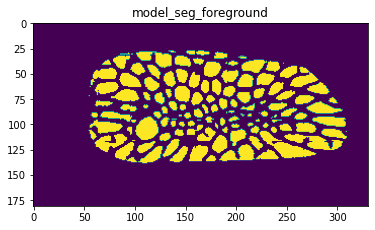

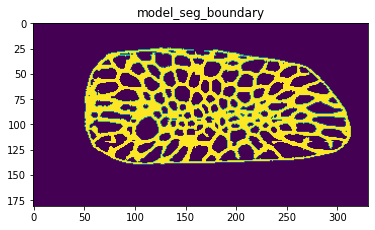

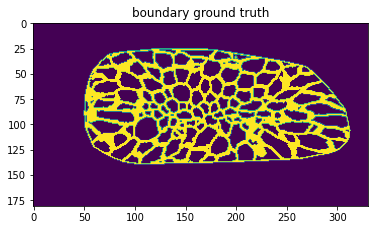

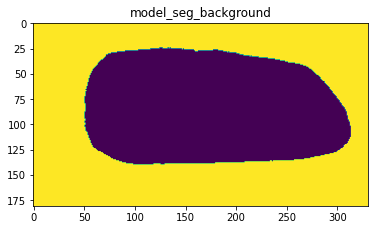

In [8]:
# show current result

N=100

plt.figure()
plt.title("raw_img")
plt.imshow(raw_img[:,:,N])
plt.figure()
plt.title("hand_seg")
plt.imshow(reassign(hand_seg[:,:,N]))
plt.figure()
plt.title("model_seg_foreground")
plt.imshow(seg_foreground_comp[:,:,N])
plt.figure()
plt.title("model_seg_boundary")
plt.imshow(seg_boundary_comp[:,:,N])
plt.figure()
plt.title("boundary ground truth")
plt.imshow(boundary_gt[:,:,N])
plt.figure()
plt.title("model_seg_background")
plt.imshow(seg_background_comp[:,:,N])

TASCAN

generate super vox by watershed

In [9]:
how_close_are_the_super_vox_to_boundary=2
min_touching_percentage=0.51

seg_foreground_erosion=1-img_3d_erosion_or_expansion(1-seg_foreground_comp, kernel_size=how_close_are_the_super_vox_to_boundary+1, device=device)
seg_foreground_super_voxel_by_ws = generate_super_vox_by_watershed(seg_foreground_erosion, connectivity=min_touching_area)

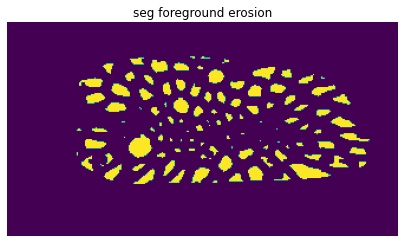

In [10]:
fig = plt.figure(figsize=(7,7))
plt.title("seg foreground erosion")
plt.axis('off')
plt.imshow(seg_foreground_erosion[:,:,N])

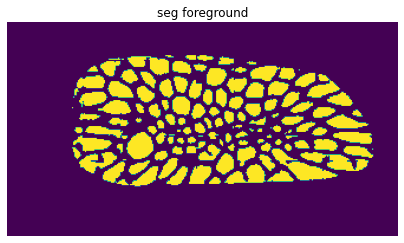

In [11]:
fig = plt.figure(figsize=(7,7))
plt.title("seg foreground")
plt.axis('off')
plt.imshow(seg_foreground_comp[:,:,N])

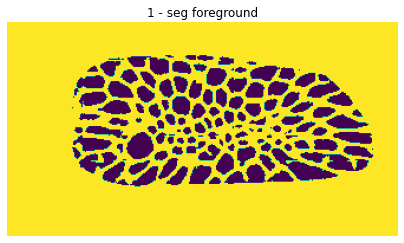

In [12]:
fig = plt.figure(figsize=(7,7))
plt.title("1 - seg foreground")
plt.axis('off')
plt.imshow(1-seg_foreground_comp[:,:,N])

In [13]:
print("There are "+str(len(np.unique(seg_foreground_super_voxel_by_ws)))+" super voxels")

There are 1949 super voxels


super voxel clustearing

In [14]:
cluster_super_vox=Cluster_Super_Vox(min_touching_area=min_touching_area, min_touching_percentage=min_touching_percentage)
cluster_super_vox.fit(seg_foreground_super_voxel_by_ws)
seg_foreground_single_cell_with_boundary = cluster_super_vox.output_3d_img

652]urrent_crop_outlayer_area: 6current_crop_outlayer_area: 137current_crop_outlayer_area: 16current_crop_outlayer_area: 99current_crop_outlayer_area: 20current_crop_outlayer_area: 14current_crop_outlayer_area: 26current_crop_outlayer_area: 7current_crop_outlayer_area: 23current_crop_outlayer_area: 1current_crop_outlayer_area: 3current_crop_outlayer_area: 31current_crop_outlayer_area: 10current_crop_outlayer_area: 6current_crop_outlayer_area: 0current_crop_outlayer_area: 18current_crop_outlayer_area: 36current_crop_outlayer_area: 62current_crop_outlayer_area: 14current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 6current_crop_outlayer_area: 51current_crop_outlayer_area: 34current_crop_outlayer_area: 0current_crop_outlayer_area: 4current_crop_outlayer_area: 2current_crop_outlayer_area: 18current_crop_outlayer_area: 32current_crop_outlayer_area: 0current_crop_outlayer_area: 12current_crop_outlayer_area: 17current_crop_outlayer_area: 0current_crop_outlaye

delete too small cells

In [15]:
min_cell_size_threshold=10
seg_foreground_single_cell_with_boundary_delete_too_small = delete_too_small_cluster(seg_foreground_single_cell_with_boundary, threshold=min_cell_size_threshold)

assign boudary voxels to their nearest cells

In [16]:
seg_final=assign_boudary_voxels_to_cells_with_watershed(seg_foreground_single_cell_with_boundary_delete_too_small, seg_boundary_comp, seg_background_comp, compactness=1)

see the final result

In [17]:
def colorful_seg(seg):
    unique_vals, val_counts = np.unique(seg, return_counts=True)
    
    background_val = unique_vals[np.argsort(val_counts)[::-1][0]]
    
    seg_RGB = []
    for i in range(seg.shape[0]):
        mask_gray = cv2.normalize(src=seg[i,:,:], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        seg_slice_RGB = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2RGB)
        seg_RGB.append(seg_slice_RGB)
    seg_RGB = np.array(seg_RGB)
    
    for idx, unique_val in enumerate(unique_vals):
        print(str(idx/len(unique_vals)), end="\r")
        if unique_val == background_val:
            COLOR = np.array([0,0,0], dtype=int)
        else:
            COLOR = np.array(np.random.choice(np.arange(256), size=3, replace=False), dtype=int)
        
        locs = np.where(seg==unique_val)
        
        for i in range(3):
            seg_RGB[locs[0], locs[1], locs[2], i] = COLOR[i]
        
    return seg_RGB

In [18]:
seg_RGB = colorful_seg(seg_final)
hand_seg_RGB = colorful_seg(hand_seg)

.044680851063829790.065957446808510640.089361702127659580.11276595744680850.134042553191489360.15744680851063830.178723404255319160.202127659574468070.2255319148936170.248936170212765960.27234042553191490.29361702127659570.31702127659574470.33829787234042550.36170212765957450.38510638297872340.40851063829787230.43191489361702130.45319148936170210.47659574468085110.49787234042553190.52127659574468090.54468085106382980.56595744680851070.58936170212765960.61063829787234050.63404255319148940.65531914893617020.67872340425531920.70212765957446810.7255319148936170.74893617021276590.77021276595744680.79361702127659570.81489361702127660.83617021276595750.85957446808510640.88085106382978730.90425531914893620.9255319148936170.9489361702127660.97021276595744680.99148936170212760.00.0207373271889400930.0414746543778801850.05760368663594470.076036866359447010.09677419354838710.11520737327188940.13364055299539170.14976958525345620.170506912442396320.19124423963133640.209677419354838720.23041474654377

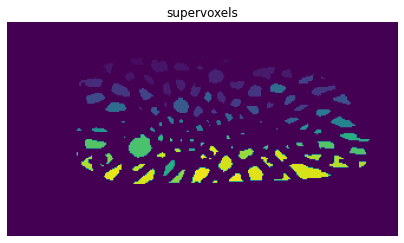

In [19]:
N=100
fig = plt.figure(figsize=(7,7))
plt.title("supervoxels")
plt.axis('off')
plt.imshow(seg_foreground_super_voxel_by_ws[:,:,N])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

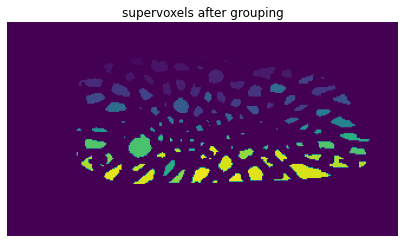

In [20]:
N=100
fig = plt.figure(figsize=(7,7))
plt.title("supervoxels after grouping")
plt.axis('off')
plt.imshow(seg_foreground_single_cell_with_boundary[:,:,N])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

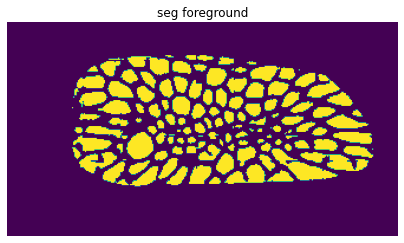

In [21]:
fig = plt.figure(figsize=(7,7))
plt.title("seg foreground")
plt.axis('off')
plt.imshow(seg_foreground_comp[:,:,N])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

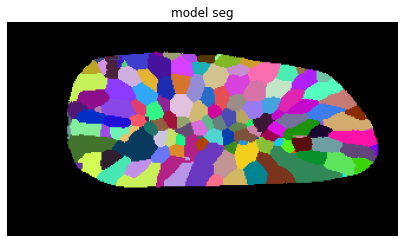

In [22]:
N=100
fig = plt.figure(figsize=(7,7))
plt.title("model seg")
plt.axis('off')
plt.imshow(seg_RGB[:,:,N,:])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

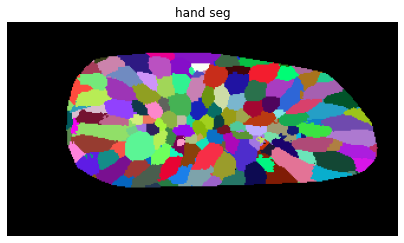

In [23]:
fig = plt.figure(figsize=(7,7))
plt.title("hand seg")
plt.axis('off')
plt.imshow(hand_seg_RGB[:,:,N,:])#,

In [24]:
# print("There are "+str(len(np.unique(seg_final)))+" cells in model prediction")
# print("There are "+str(len(np.unique(hand_seg)))+" cells in hand seg")

calculate accuracy

In [25]:
ARI = adjusted_rand_score(hand_seg.flatten(), seg_final.flatten())
ARE = adapted_rand_error(hand_seg.astype(int).flatten(), seg_final.astype(int).flatten())
VOI_val = VOI(seg_final.astype(int),hand_seg.astype(int))

In [26]:
print("ARI: "+str(ARI))
print("ARE: "+str(ARE))
print("VOI: "+str(VOI_val))

ARI: 0.9887763567433208
ARE: (0.37053370287142984, 0.6709792901489295, 0.5927907700856463)
VOI: (1.1831407145760584, 1.2149591947865765)


In [27]:
def img_3d_interpolate(img_3d, output_size, device = torch.device('cpu'), mode='nearest'):
    img_3d = img_3d.reshape(1,1,img_3d.shape[0],img_3d.shape[1],img_3d.shape[2])
    img_3d=torch.from_numpy(img_3d).float().to(device)
    img_3d=torch.nn.functional.interpolate(img_3d, size=output_size, mode='nearest')
    img_3d=img_3d.detach().cpu().numpy()
    img_3d=img_3d.reshape(img_3d.shape[2],img_3d.shape[3],img_3d.shape[4])
    
    return img_3d

scale_factor = 0.5
org_shape = seg_final.shape
output_size = (int(org_shape[0]*scale_factor), int(org_shape[1]*scale_factor), int(org_shape[2]*scale_factor))
print(str(org_shape)+" --> "+str(output_size))

(181, 331, 160) --> (90, 165, 80)


In [28]:
accuracy=IOU_and_Dice_Accuracy(img_3d_interpolate(hand_seg, output_size = output_size), img_3d_interpolate(seg_final, output_size = output_size))
accuracy_record=accuracy.cal_accuracy_II()

iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

print('avg iou: '+str(np.mean(accuracy_record[:,1])))
print('avg dice: '+str(np.mean(accuracy_record[:,2])))

rogress: 20.212765957446805%progress: 20.74468085106383%progress: 21.54255319148936%progress: 22.340425531914892%progress: 23.670212765957448%progress: 25.0%progress: 26.329787234042552%progress: 27.393617021276594%progress: 27.925531914893615%progress: 28.98936170212766%progress: 30.319148936170215%progress: 32.180851063829785%progress: 32.97872340425532%progress: 34.57446808510639%progress: 35.638297872340424%progress: 36.702127659574465%progress: 37.765957446808514%progress: 38.297872340425535%progress: 39.62765957446808%progress: 40.691489361702125%progress: 41.755319148936174%progress: 42.5531914893617%progress: 43.61702127659575%progress: 44.41489361702128%progress: 45.47872340425532%progress: 46.808510638297875%progress: 47.6063829787234%progress: 48.67021276595745%progress: 49.734042553191486%progress: 50.53191489361703%progress: 51.329787234042556%progress: 52.12765957446809%progress: 53.72340425531915%progress: 54.78723404255319%progress: 55.85106382978723%progress: 56.648936

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/259725777.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/259725777.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:,2

### seg all imgs

In [29]:
def img_3d_interpolate(img_3d, output_size, device = torch.device('cpu'), mode='nearest'):
    img_3d = img_3d.reshape(1,1,img_3d.shape[0],img_3d.shape[1],img_3d.shape[2])
    img_3d=torch.from_numpy(img_3d).float().to(device)
    img_3d=torch.nn.functional.interpolate(img_3d, size=output_size, mode='nearest')
    img_3d=img_3d.detach().cpu().numpy()
    img_3d=img_3d.reshape(img_3d.shape[2],img_3d.shape[3],img_3d.shape[4])
    
    return img_3d

def pipeline(raw_img, hand_seg, model, device,
             crop_cube_size, stride,
             how_close_are_the_super_vox_to_boundary=2,
             min_touching_area=30,
             min_touching_percentage=0.51,
             min_cell_size_threshold=1,
             transposes = [[0,1,2]], reverse_transposes = [[0,1,2]]):
    
    seg_final=segment_super_vox_3_channel(raw_img, model, device,
                                          crop_cube_size=crop_cube_size, stride=stride,
                                          how_close_are_the_super_vox_to_boundary=how_close_are_the_super_vox_to_boundary,
                                          min_touching_area=min_touching_area,
                                          min_touching_percentage=min_touching_percentage,
                                          min_cell_size_threshold=min_cell_size_threshold,
                                          transposes = transposes, reverse_transposes = reverse_transposes)
    
    ari = adjusted_rand_score(hand_seg.flatten(), seg_final.flatten())
    voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))
    
    scale_factor = 0.5
    org_shape = seg_final.shape
    output_size = (int(org_shape[0]*scale_factor), int(org_shape[1]*scale_factor), int(org_shape[2]*scale_factor))
    print(str(org_shape)+" --> "+str(output_size))
    
    accuracy=IOU_and_Dice_Accuracy(img_3d_interpolate(hand_seg, output_size = output_size),
                                   img_3d_interpolate(seg_final, output_size = output_size))
    accuracy_record=accuracy.cal_accuracy_II()
    hand_seg_after_accuracy=accuracy.gt
    seg_final_after_accuracy=accuracy.pred
    
    return accuracy_record, hand_seg_after_accuracy, seg_final_after_accuracy, ari, voi, seg_final

In [30]:
# mass process
seg_final_dict={}
accuracy_record_dict = {}
ari_dict = {}
voi_dict = {}
for test_file in HMS_data_dict_test.keys():
    print(test_file)
    raw_img=np.load(HMS_data_dict_test[test_file]["raw"])
    hand_seg=np.load(HMS_data_dict_test[test_file]["ins"])
    accuracy_record, hand_seg_after_accuracy, seg_final_after_accuracy, ari, voi, seg_final=\
    pipeline(raw_img, hand_seg, model, device,
             crop_cube_size=64,
             stride=32)
    
    seg_final_dict[test_file] = seg_final
    accuracy_record_dict[test_file] = accuracy_record
    ari_dict[test_file] = ari
    voi_dict[test_file] = voi
    
    iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
    print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
    print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
    iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
    print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
    print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

    print('avg iou: '+str(np.mean(accuracy_record[:,1])))
    print('avg dice: '+str(np.mean(accuracy_record[:,2])))
    print("ari: "+str(ari))
    print("voi: "+str(voi))
    print("----------")

135
Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]
s of segment_3d_img: 99%Get model semantic seg by combination
rrent_crop_outlayer_area: 6current_crop_outlayer_area: 137current_crop_outlayer_area: 14current_crop_outlayer_area: 99current_crop_outlayer_area: 20current_crop_outlayer_area: 3current_crop_outlayer_area: 15current_crop_outlayer_area: 0current_crop_outlayer_area: 1current_crop_outlayer_area: 0current_crop_outlayer_area: 8current_crop_outlayer_area: 24current_crop_outlayer_area: 29current_crop_outlayer_area: 16current_crop_outlayer_area: 5current_crop_outlayer_area: 0current_crop_outlayer_area: 1current_crop_outlayer_area: 0current_crop_outlayer_area: 123current_crop_outlayer_area: 0current_crop_outlayer_area: 8current_crop_outlayer_area: 0current_crop_outlayer_area: 34current_crop_outlayer_area: 0current_crop_outlayer_area: 1current_crop_outlayer_area: 0current_crop_outlayer_area: 4current_crop_outlayer_area: 23current_crop_outlayer_a

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/1505333415.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)
rogress: 30.319148936170215%progress: 32.180851063829785%progress: 32.97872340425532%progress: 34.840425531914896%progress: 36.43617021276596%progress: 37.5%progress: 38.297872340425535%progress: 39.62765957446808%progress: 40.691489361702125%progress: 41.755319148936174%progress: 42.819148936170215%progress: 44.41489361702128%progress: 45.744680851063826%progress: 47.07446808510639%progress: 47.87234042553192%progress: 49.202127659574465%progress: 50.53191489361703%progress: 51.59574468085106%progress: 53.191489361702125%progress: 54.78723404255319%progress: 55.85106382978723%progress: 56.64893617021277%progress: 57.71276595744681%progress: 59.04255319148937%progress: 60.1063829787234%progress: 61.170212765957444%progress: 61.702127659574465%progress: 62.5%progress: 63.297872340425535%progress: 64.36170212765957%progress: 65.42553191489363%progress: 66.48936170212765%progress: 67.81914893617021%progress: 68.61702127659575%progress: 69.9468085106383%pr

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:

cell count accuracy iou >0.7: 0.3776595744680851
cell count accuracy dice >0.7: 0.5558510638297872
cell count accuracy iou >0.5: 0.598404255319149
cell count accuracy dice >0.5: 0.75
avg iou: 0.5204518265388114
avg dice: 0.6381698403943409
ari: 0.9887813120768859
voi: (1.2387309735901193, 1.1821521195960722)
----------
120
Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]
s of segment_3d_img: 99%Get model semantic seg by combination
032]current_crop_outlayer_area: 115current_crop_outlayer_area: 0current_crop_outlayer_area: 16current_crop_outlayer_area: 17current_crop_outlayer_area: 2current_crop_outlayer_area: 0current_crop_outlayer_area: 4current_crop_outlayer_area: 127current_crop_outlayer_area: 3current_crop_outlayer_area: 7current_crop_outlayer_area: 4current_crop_outlayer_area: 0current_crop_outlayer_area: 21current_crop_outlayer_area: 38current_crop_outlayer_area: 39current_crop_outlayer_area: 2current_crop_outlayer_area: 0current_crop_outlay

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/1505333415.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)
rogress: 4.775280898876404%progress: 5.617977528089887%progress: 6.460674157303371%progress: 7.584269662921349%progress: 8.707865168539326%progress: 9.831460674157304%progress: 10.955056179775282%progress: 11.797752808988763%progress: 12.921348314606742%progress: 14.606741573033707%progress: 15.730337078651685%progress: 16.853932584269664%progress: 17.696629213483146%progress: 18.53932584269663%progress: 19.9438202247191%progress: 20.786516853932586%progress: 21.629213483146067%progress: 22.191011235955056%progress: 23.03370786516854%progress: 24.15730337078652%progress: 24.719101123595504%progress: 25.56179775280899%progress: 26.40449438202247%progress: 26.96629213483146%progress: 27.52808988764045%progress: 28.08988764044944%progress: 28.651685393258425%progress: 29.49438202247191%progress: 30.337078651685395%progress: 31.179775280898873%progress: 31.741573033707866%progress: 32.58426966292135%progress: 33.42696629213483%progress: 33.98876404494382%p

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:

cell count accuracy iou >0.7: 0.4410112359550562
cell count accuracy dice >0.7: 0.6207865168539326
cell count accuracy iou >0.5: 0.651685393258427
cell count accuracy dice >0.5: 0.8061797752808989
avg iou: 0.5608052647197777
avg dice: 0.6762947715829346
ari: 0.9903133216110687
voi: (1.1912324053886543, 1.1117598943602993)
----------
65
Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]
s of segment_3d_img: 99%Get model semantic seg by combination
03]]op_outlayer_area: 237current_crop_outlayer_area: 40current_crop_outlayer_area: 21current_crop_outlayer_area: 63current_crop_outlayer_area: 130current_crop_outlayer_area: 73current_crop_outlayer_area: 79current_crop_outlayer_area: 78current_crop_outlayer_area: 36current_crop_outlayer_area: 157current_crop_outlayer_area: 121current_crop_outlayer_area: 4current_crop_outlayer_area: 88current_crop_outlayer_area: 89current_crop_outlayer_area: 65current_crop_outlayer_area: 22current_crop_outlayer_area: 29curre

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/1505333415.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)
cell count accuracy iou >0.7: 0.279605263157894756842105%progress: 26.31578947368421%progress: 26.973684210526315%progress: 27.960526315789476%progress: 28.947368421052634%progress: 29.605263157894733%progress: 30.592105263157894%progress: 31.57894736842105%progress: 32.56578947368421%progress: 33.55263157894737%progress: 34.21052631578947%progress: 35.526315789473685%progress: 36.51315789473684%progress: 37.17105263157895%progress: 38.15789473684211%progress: 39.14473684210527%progress: 40.131578947368425%progress: 41.118421052631575%progress: 42.10526315789473%progress: 43.09210526315789%progress: 43.75%progress: 45.39473684210527%progress: 46.381578947368425%progress: 47.368421052631575%progress: 48.35526315789473%progress: 49.67105263157895%progress: 50.98684210526315%progress: 51.973684210526315%progress: 53.289473684210535%progress: 54.60526315789473%progress: 56.25%progress: 57.23684210526315%progress: 57.89473684210527%progress: 59.539473684210

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:

s of segment_3d_img: 99%Get model semantic seg by combination
3 1219]1408 1414]nt_crop_outlayer_area: 5current_crop_outlayer_area: 47current_crop_outlayer_area: 0current_crop_outlayer_area: 83current_crop_outlayer_area: 0current_crop_outlayer_area: 34current_crop_outlayer_area: 6current_crop_outlayer_area: 8current_crop_outlayer_area: 13current_crop_outlayer_area: 45current_crop_outlayer_area: 25current_crop_outlayer_area: 13current_crop_outlayer_area: 88current_crop_outlayer_area: 2current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 3current_crop_outlayer_area: 44current_crop_outlayer_area: 24current_crop_outlayer_area: 8current_crop_outlayer_area: 0current_crop_outlayer_area: 88current_crop_outlayer_area: 46current_crop_outlayer_area: 93current_crop_outlayer_area: 106current_crop_outlayer_area: 75current_crop_outlayer_area: 41current_crop_outlayer_area: 71current_crop_outlayer_area: 4current_crop_outlayer_area: 17current_

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/1505333415.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)
cell count accuracy iou >0.7: 0.3389355742296919
cell count accuracy dice >0.7: 0.4677871148459384
cell count accuracy iou >0.5: 0.5014005602240896
cell count accuracy dice >0.5: 0.6694677871148459
avg iou: 0.47539210659503955
avg dice: 0.5889661888981953
ari: 0.9913964471796839
voi: (1.0957306587105087, 1.3184176191628276)
----------


/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:

In [31]:
for item in seg_final_dict.keys():
    print(item)
    accuracy_record = accuracy_record_dict[item]
    ari = ari_dict[item]
    voi = voi_dict[item]
    iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
    print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
    print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
    iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
    print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
    print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

    print('avg iou: '+str(np.mean(accuracy_record[:,1])))
    print('avg dice: '+str(np.mean(accuracy_record[:,2])))
    print("ari: "+str(ari))
    print("voi: "+str(voi))
    print("----------")




135
cell count accuracy iou >0.7: 0.3776595744680851
cell count accuracy dice >0.7: 0.5558510638297872
cell count accuracy iou >0.5: 0.598404255319149
cell count accuracy dice >0.5: 0.75
avg iou: 0.5204518265388114
avg dice: 0.6381698403943409
ari: 0.9887813120768859
voi: (1.2387309735901193, 1.1821521195960722)
----------
120
cell count accuracy iou >0.7: 0.4410112359550562
cell count accuracy dice >0.7: 0.6207865168539326
cell count accuracy iou >0.5: 0.651685393258427
cell count accuracy dice >0.5: 0.8061797752808989
avg iou: 0.5608052647197777
avg dice: 0.6762947715829346
ari: 0.9903133216110687
voi: (1.1912324053886543, 1.1117598943602993)
----------
65
cell count accuracy iou >0.7: 0.27960526315789475
cell count accuracy dice >0.7: 0.42105263157894735
cell count accuracy iou >0.5: 0.46710526315789475
cell count accuracy dice >0.5: 0.6710526315789473
avg iou: 0.4862710802262882
avg dice: 0.6148497683860018
ari: 0.9909201284033261
voi: (1.2584500794969642, 1.3278350462874742)
-----

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/583679840.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_2431/583679840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:,2

In [32]:
# see the difference for supervoxels

how_close_are_the_super_vox_to_boundary=2
min_touching_percentage=0.51

seg_foreground_erosion=1-img_3d_erosion_or_expansion(1-seg_foreground_comp, kernel_size=how_close_are_the_super_vox_to_boundary+1, device=device)
seg_foreground_super_voxel_by_ws = generate_super_vox_by_watershed(seg_foreground_erosion, connectivity=min_touching_area)

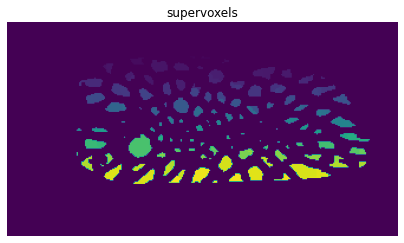

In [33]:
N=100
fig = plt.figure(figsize=(7,7))
plt.title("supervoxels")
plt.axis('off')
plt.imshow(seg_foreground_super_voxel_by_ws[:,:,N])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)
